In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [2]:
import sys
sys.path.append('..')
sys.path.append('../external_dependencies')

In [3]:
import dnnlib
import torch
import pickle
from torch import nn
import numpy as np
from PIL import Image, ImageDraw
from torch.nn import functional as F

from einops import rearrange
from typing import List, Union
from matplotlib import pyplot as plt
from torchvision.utils import make_grid

In [4]:
device = "cuda"

In [5]:
@torch.no_grad()
def render_tensor(img: torch.Tensor, normalize: bool = True, nrow: int = 8) -> Image.Image:
    if type(img) == list:
        img = torch.cat([i if len(i.shape) == 4 else i[None, ...] for i in img], dim=0).expand(-1, 3, -1, -1)
    elif len(img.shape) == 3:
        img = img.expand(3, -1, -1)
    elif len(img.shape) == 4:
        img = img.expand(-1, 3, -1, -1)
    
    img = img.squeeze()
    
    if normalize:
        img = img / 2 + .5
    
    if len(img.shape) == 3:
        return Image.fromarray((img.permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8))
    elif len(img.shape) == 2:
        return Image.fromarray((img.cpu().numpy() * 255).astype(np.uint8))
    elif len(img.shape) == 4:
        return Image.fromarray((make_grid(img, nrow=nrow).permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8))

In [6]:
def to_tensor(img: Union[Image.Image, np.ndarray], normalize=True) -> torch.Tensor:
    if isinstance(img, Image.Image):
        img = np.array(img)
        if len(img.shape) > 2:
            img = img.transpose(2, 0, 1)
        else:
            img = img[None, ...]
    else:
        if img.shape[0] == img.shape[1]:
            img = img.transpose(2, 0, 1)
    if normalize:
        img = torch.from_numpy(img).to(torch.float32) / 127.5 - 1
    else:
        img = torch.from_numpy(img).to(torch.float32) / 255.
    return img[None, ...].to(device)

In [7]:
import pickle
import random as r
from camera_utils import LookAtPoseSampler, FOV_to_intrinsics
from torch_utils import misc

In [8]:
from tqdm import tqdm
for name in ['bool', 'int', 'float', 'complex', 'object', 'unicode', 'str']:
    setattr(np, name, getattr(np, name + "_"))

In [9]:
from external_dependencies.decalib import DECAWrapper
deca = DECAWrapper(device)

Load DECA and FLAME ...


/home/kevin/anaconda3/envs/nerffaceshop/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/kevin/anaconda3/envs/nerffaceshop/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


creating the FLAME Decoder
trained model found. load /home/kevin/Output/03.NeRFFaceShop/external_dependencies/data/deca_model.tar


/home/kevin/Output/03.NeRFFaceShop/nerffaceshop/../external_dependencies/decalib/deca.py:87: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path

## Load the Model

In [10]:
from training.networks_animation_lit import TriPlaneGenerator as Generator

In [11]:
with open("../data/vfhq-celebv-text-64.pkl", "rb") as f:
    _G = pickle.load(f)["G_ema"].to(device).eval().requires_grad_(False)
G = Generator(*_G.init_args, **_G.init_kwargs).eval().requires_grad_(False).to(device)
misc.copy_params_and_buffers(_G, G)

In [12]:
with open("../data/greek_statue-64.pkl", "rb") as f:
    _G = pickle.load(f)["G_ema"].to(device).eval().requires_grad_(False)
G_greek = Generator(*_G.init_args, **_G.init_kwargs).eval().requires_grad_(False).to(device)
misc.copy_params_and_buffers(_G, G_greek)

In [14]:
with open("../data/animate-64.pkl", "rb") as f:
    _G = pickle.load(f)["G_ema"].to(device).eval().requires_grad_(False)
G_animate = Generator(*_G.init_args, **_G.init_kwargs).eval().requires_grad_(False).to(device)
misc.copy_params_and_buffers(_G, G_animate)

In [15]:
G.exp_mask = (torch.from_numpy(np.array(Image.open('../data/plane_0.png').convert('L'))).to(torch.float32) / 255.)[None, None, :, :].to(device)
G_greek.exp_mask = (torch.from_numpy(np.array(Image.open('../data/plane_0.png').convert('L'))).to(torch.float32) / 255.)[None, None, :, :].to(device)
G_animate.exp_mask = (torch.from_numpy(np.array(Image.open('../data/plane_0.png').convert('L'))).to(torch.float32) / 255.)[None, None, :, :].to(device)

In [16]:
fov_deg = 18.837
intrinsics = FOV_to_intrinsics(fov_deg, device=device)
cam_pivot = torch.tensor(G.rendering_kwargs.get('avg_camera_pivot', [0, 0, 0]), device=device)
cam_radius = G.rendering_kwargs.get('avg_camera_radius', 2.7)
conditioning_cam2world_pose = LookAtPoseSampler.sample(np.pi/2, np.pi/2, cam_pivot, radius=cam_radius, device=device)
conditioning_params = torch.cat([conditioning_cam2world_pose.reshape(-1, 16), intrinsics.reshape(-1, 9)], 1)

In [17]:
from training.encoder import Encoder
encoder = Encoder(50 + 3, 64, 128, 3, 5).eval().requires_grad_(False).to(device)
encoder.load_state_dict(torch.load('../data/encoder.pth'))

/tmp/ipykernel_85564/3563039381.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  encoder.load_state_dict(torch.load('../data/encoder.pth'))


<All keys matched successfully>

## Generating the Media

In [18]:
dataset_kwargs = dnnlib.EasyDict(
    class_name='training.dataset.ImageFolderDataset', 
    path="/path/to/FFHQ/", use_labels=True, max_size=None, xflip=False)
dataset_obj = dnnlib.util.construct_class_by_name(**dataset_kwargs)

In [37]:
z = torch.from_numpy(np.random.RandomState(0).randn(1, G.z_dim)).to(device)
w = G.backbone.mapping(z, conditioning_params.expand(len(z), -1), 0.5)

In [59]:
cam2world_pose = LookAtPoseSampler.sample(np.pi/2, np.pi/2, cam_pivot, radius=cam_radius, device=device)
camera_params = torch.cat([cam2world_pose.reshape(-1, 16), intrinsics.reshape(-1, 9)], 1)

### Reproduce the Expression and Lighting Condition of the Reference Image (on the left)

In [112]:
image, c, sh = dataset_obj[18]
image = to_tensor(image)
c = torch.from_numpy(c).reshape(1, -1).to(device).float()
sh = torch.from_numpy(sh).reshape(1, -1).to(device).float()

In [113]:
real_codedict = deca.encode(render_tensor(image))
real_exp = real_codedict['exp'].squeeze()[:, None]
real_pose = real_codedict['pose'].squeeze()[:3, None]
real_jaw = real_codedict['pose'].squeeze()[3:, None]

wd = encoder(torch.cat((real_exp, real_jaw), dim=0).view(1, -1))[:, None, :] + G.backbone.dmapping.w_avg[None, None, :]

In [114]:
wl = G.backbone.lmapping(None, sh)

In [115]:
out = G.synthesis(
    w, wd.expand(len(w), 8, -1), wl.expand(len(w), -1, -1), camera_params.expand(len(w), -1), 
    use_exp_mask=True
)

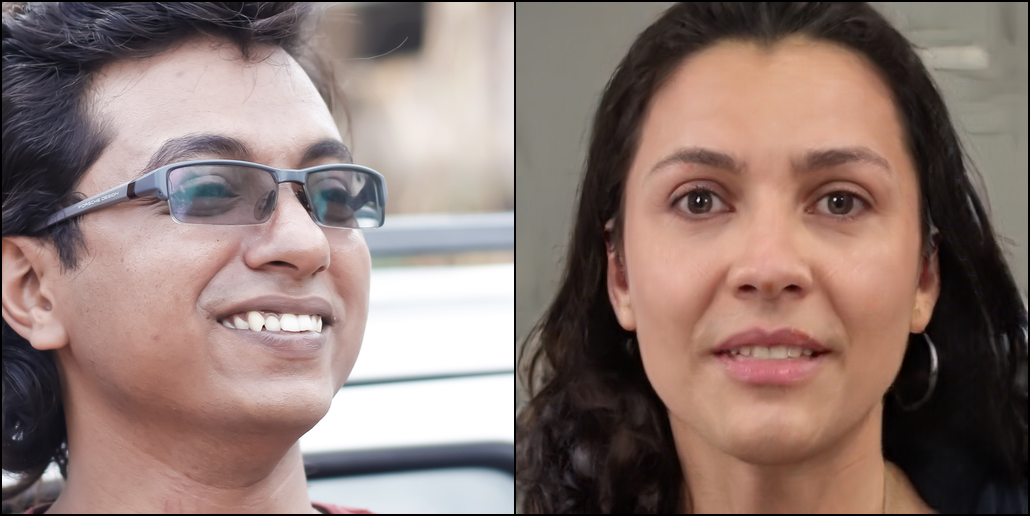

In [116]:
render_tensor([image, out["image"].clamp(-1, 1)])

In [77]:
image, c, sh = dataset_obj[8]
image = to_tensor(image)
c = torch.from_numpy(c).reshape(1, -1).to(device).float()
sh = torch.from_numpy(sh).reshape(1, -1).to(device).float()

In [78]:
real_codedict = deca.encode(render_tensor(image))
real_exp = real_codedict['exp'].squeeze()[:, None]
real_pose = real_codedict['pose'].squeeze()[:3, None]
real_jaw = real_codedict['pose'].squeeze()[3:, None]

wd = encoder(torch.cat((real_exp, real_jaw), dim=0).view(1, -1))[:, None, :] + G.backbone.dmapping.w_avg[None, None, :]

In [79]:
wl = G.backbone.lmapping(None, sh)

In [80]:
out = G.synthesis(
    w, wd.expand(len(w), 8, -1), wl.expand(len(w), -1, -1), camera_params.expand(len(w), -1), 
    use_exp_mask=True
)

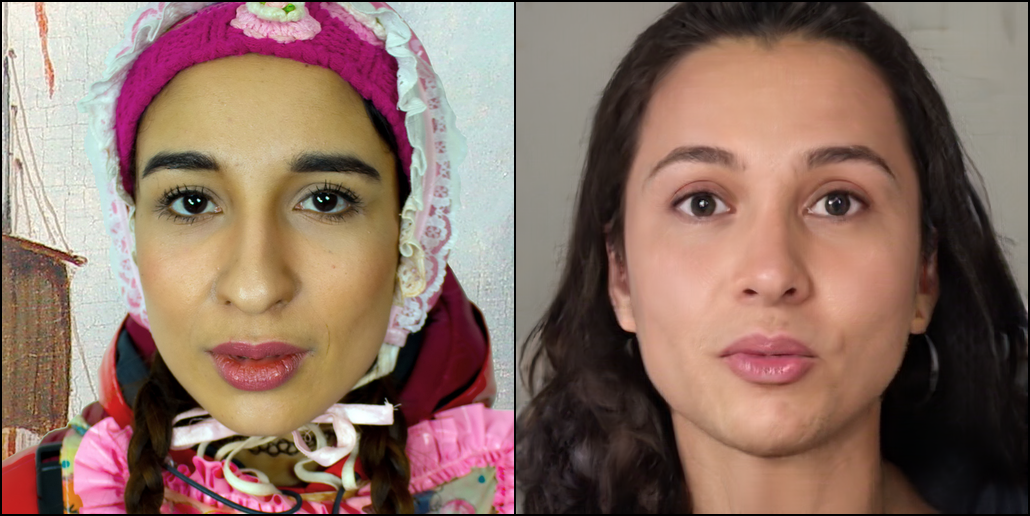

In [81]:
render_tensor([image, out["image"].clamp(-1, 1)])

In [117]:
image, c, sh = dataset_obj[0]
image = to_tensor(image)
c = torch.from_numpy(c).reshape(1, -1).to(device).float()
sh = torch.from_numpy(sh).reshape(1, -1).to(device).float()

In [118]:
real_codedict = deca.encode(render_tensor(image))
real_exp = real_codedict['exp'].squeeze()[:, None]
real_pose = real_codedict['pose'].squeeze()[:3, None]
real_jaw = real_codedict['pose'].squeeze()[3:, None]

wd = encoder(torch.cat((real_exp, real_jaw), dim=0).view(1, -1))[:, None, :] + G.backbone.dmapping.w_avg[None, None, :]

In [119]:
wl = G.backbone.lmapping(None, sh)

In [120]:
out = G.synthesis(
    w, wd.expand(len(w), 8, -1), wl.expand(len(w), -1, -1), camera_params.expand(len(w), -1), 
    use_exp_mask=True
)

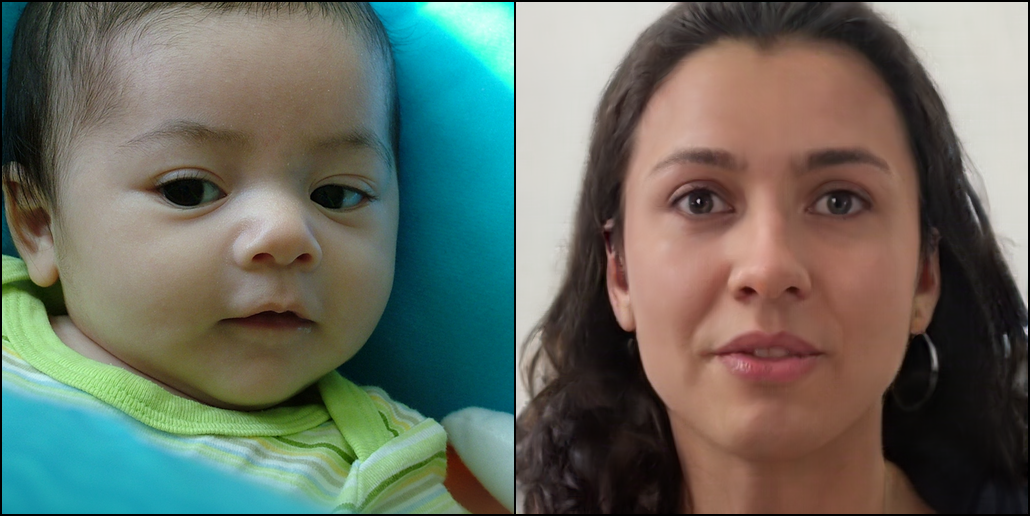

In [121]:
render_tensor([image, out["image"].clamp(-1, 1)])

## Generate Media from Other Domains

In [126]:
z = torch.from_numpy(np.random.RandomState(0).randn(1, G.z_dim)).to(device)

In [132]:
out_greek = G_greek.synthesis(
    G_greek.backbone.mapping(z, conditioning_params.expand(len(z), -1), 0.5), None, G_greek.backbone.lmapping.w_avg[None, None, :].expand(-1, 5, -1), camera_params.expand(len(w), -1), 
    use_exp_mask=True
)
out_animate = G_animate.synthesis(
    G_animate.backbone.mapping(z, conditioning_params.expand(len(z), -1), 0.5), None, G_greek.backbone.lmapping.w_avg[None, None, :].expand(-1, 5, -1), camera_params.expand(len(w), -1), 
    use_exp_mask=True
)

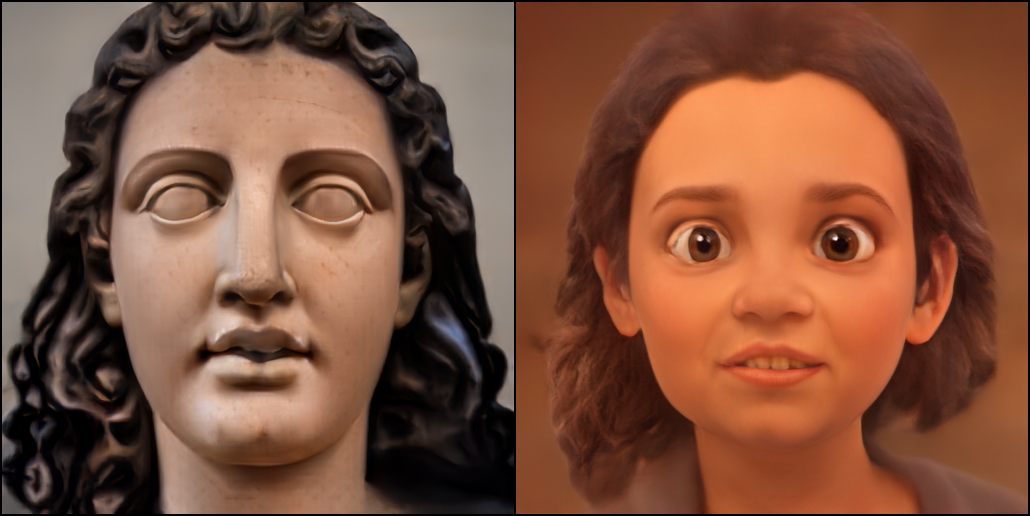

In [133]:
render_tensor([out_greek["image"].clamp(-1, 1), out_animate["image"].clamp(-1, 1)])